In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from jupyterthemes import jtplot
jtplot.style(theme=’monokai’, context=’notebook’, ticks=True, grid=False)

# Overall Prediction (Country-wise)

In [200]:
df = pd.read_csv('Dataset/Unemployment_Rate_Country_wise_for_2010_2020.csv')
df.head()

,Country,Year,Month,Value,Year_Month
0,Austria,2010,1,2775.8,2010M01
1,Austria,2010,2,2847.2,2010M02
2,Austria,2010,3,2632.2,2010M03
3,Austria,2010,4,2826.6,2010M04
4,Austria,2010,5,2695.9,2010M05


In [201]:
indexed_df = df.set_index('Year_Month')

In [202]:
# Let's do for Spain now

indexed_df = indexed_df[indexed_df['Country']=='Spain']

In [203]:
ts = indexed_df['Value']
ts.head()

Year_Month
2010M01     54449.8
2010M02     55234.1
2010M03     55998.7
2010M04     56638.2
2010M05     56714.5
Name: Value, dtype: float64

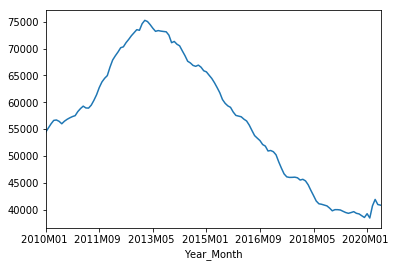

In [204]:
ts.plot()

# Stationarity Check using ADF Test

In [205]:
from statsmodels.tsa.stattools import adfuller

In [206]:
def check_stationarity(timeseries):
    
    # Determine rolling statistics
    rollmean = timeseries.rolling(window=52,center=False).mean()
    rollstd = timeseries.rolling(window=52,center=False).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rollmean, color="red", label="Rolling Mean")
    std = plt.plot(rollstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block=False)
    
    # Perform Dickey Fuller Test
    print ("Results of Dickey Fuller Test")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=['Test statistics', 'p-value', '#Lags used', 'No of Observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


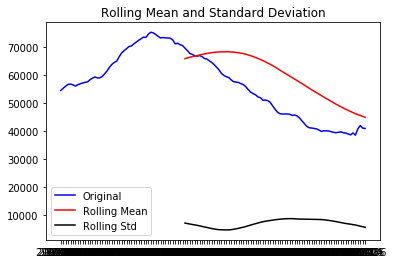

Results of Dickey Fuller Test
Test statistics             -1.988852
p-value                      0.291482
#Lags used                  13.000000
No of Observations used    112.000000
Critical Value (1%)         -3.490131
Critical Value (5%)         -2.887712
Critical Value (10%)        -2.580730
dtype: float64


In [207]:
check_stationarity(ts)

Clearly a non-stationary data

## Convert data into stationary data by taking logarithm and differencing

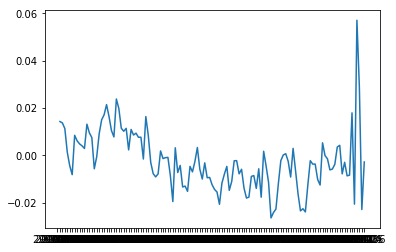

In [208]:
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

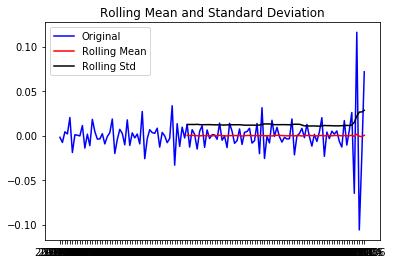

Results of Dickey Fuller Test
Test statistics           -7.201631e+00
p-value                    2.357214e-10
#Lags used                 1.200000e+01
No of Observations used    1.100000e+02
Critical Value (1%)       -3.491245e+00
Critical Value (5%)       -2.888195e+00
Critical Value (10%)      -2.580988e+00
dtype: float64


In [235]:
ts_log_diff.dropna(inplace=True)
check_stationarity(ts_log_diff)

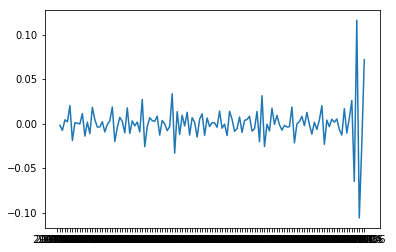

In [234]:
ts_log_diff = ts_log_diff - ts_log_diff.shift()
plt.plot(ts_log_diff)

The above process was run repeatedly till we reached the p-value < 0.05

# PACF and ACF

In [212]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

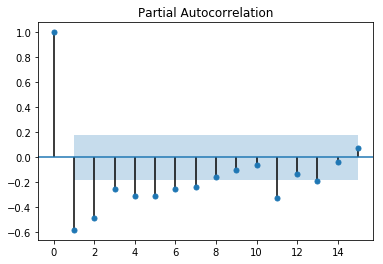

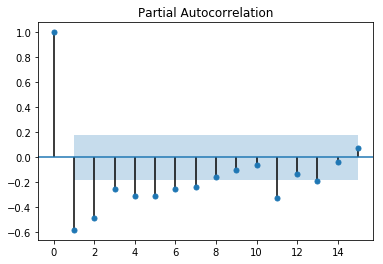

In [236]:
# Plot PACF

lag_pacf = pacf(ts_log_diff, nlags=15, method='ols')
sm.graphics.tsa.plot_pacf(ts_log_diff, lags=15)

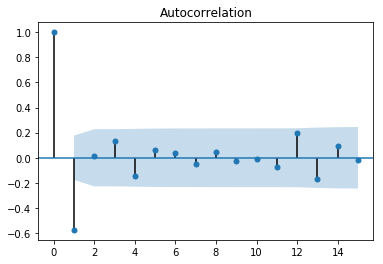

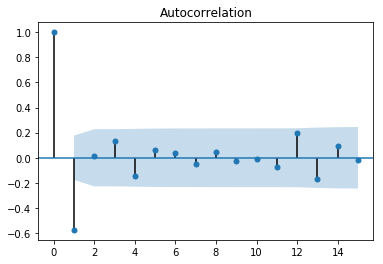

In [237]:
# Plot ACF

lag_acf = acf(ts_log_diff, nlags=15)
sm.graphics.tsa.plot_acf(ts_log_diff, lags=15)

In [238]:
# Training the ARIMA Model

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(1,1,1))
ouput_arima = model.fit(disp=-1)

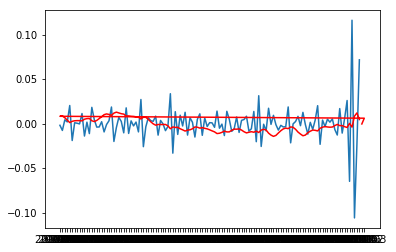

In [239]:
plt.plot(ts_log_diff)
plt.plot(ouput_arima.fittedvalues, color='red')

In [240]:
print(ouput_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  125
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 395.146
Method:                       css-mle   S.D. of innovations              0.010
Date:                Mon, 24 Aug 2020   AIC                           -782.291
Time:                        16:12:27   BIC                           -770.978
Sample:                             1   HQIC                          -777.695
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.005     -0.074      0.941      -0.010       0.009
ar.L1.D.Value     0.9576      0.039     24.837      0.000       0.882       1.033
ma.L1.D.Value    -0.7592      0.101     

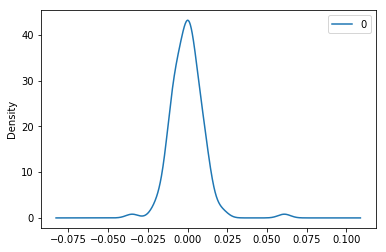

In [241]:
pd.DataFrame(ouput_arima.resid).plot(kind='kde')

# Predictions

In [242]:
predictions_data_diff = pd.Series(ouput_arima.fittedvalues, copy=True)
predictions_data_diff.head()

Year_Month
2010M02    -0.000352
2010M03     0.006134
2010M04     0.008274
2010M05     0.008713
2010M06     0.006613
dtype: float64

In [243]:
ts_log.head()

Year_Month
2010M01     10.905034
2010M02     10.919336
2010M03     10.933084
2010M04     10.944439
2010M05     10.945785
Name: Value, dtype: float64

In [244]:
predictions_data_diff.shape

(125,)

In [245]:
ts_log.shape

(126,)

In [246]:
predictions_data_diff_cumsum = predictions_data_diff.cumsum()
predictions_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_log = predictions_log.add(predictions_data_diff_cumsum, fill_value=0)

In [247]:
predictions_log.head()

Year_Month
2010M01     10.905034
2010M02     10.904682
2010M03     10.910816
2010M04     10.919090
2010M05     10.927803
dtype: float64

In [248]:
predictions_log.shape

(126,)

Text(0.5, 1.0, 'RMSE 2958.8769')

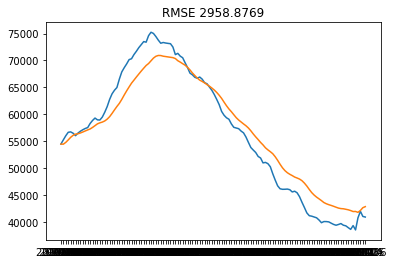

In [249]:
predictions = np.exp(predictions_log)
plt.plot(ts)
plt.plot(predictions)
plt.title("RMSE %.4f"% np.sqrt(sum((predictions-ts)**2)/len(ts)))

# Splitting into training and testing sets

In [250]:
len(ts_log)

126

In [262]:
import warnings
warnings.filterwarnings('ignore')

size = int(len(ts_log) - 100)
print("Size", size)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

#print(history)
#print(ts_log)
print ("Predicted vs Actual Counts")
print ('\n')

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print ("Predicted = %f, Actual = %f"% (np.exp(yhat), np.exp(obs)))
        

Size 26
Predicted vs Actual Counts


Predicted = 68823.959322, Actual = 68646.700000
Predicted = 69301.558866, Actual = 69351.200000
Predicted = 70034.758742, Actual = 70148.100000
Predicted = 70898.403838, Actual = 70311.800000
Predicted = 70581.477592, Actual = 71087.100000
Predicted = 71913.482478, Actual = 71702.300000
Predicted = 72293.696012, Actual = 72379.600000
Predicted = 73067.108926, Actual = 72935.900000
Predicted = 73524.607026, Actual = 73499.300000
Predicted = 74116.008489, Actual = 73387.800000
Predicted = 73548.619695, Actual = 74601.400000
Predicted = 75643.992615, Actual = 75234.700000
Predicted = 75854.822306, Actual = 75012.300000
Predicted = 75215.387361, Actual = 74436.700000
Predicted = 74442.283069, Actual = 73764.900000
Predicted = 73645.983956, Actual = 73191.900000
Predicted = 73082.800319, Actual = 73330.000000
Predicted = 73702.535622, Actual = 73232.700000
Predicted = 73364.834608, Actual = 73163.000000
Predicted = 73330.245657, Actual = 73102.400000
Pre

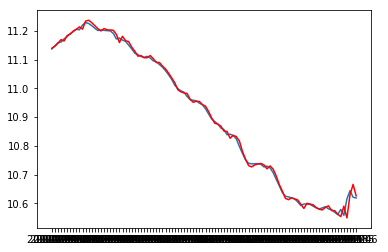

In [263]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Evaluating MSE

In [264]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print ('Test MSE (Mean Squared Error): %.6f'% error)

Test MSE (Mean Squared Error): 0.000133


# Forecasting future Unemployment Count

In [331]:
forecasted_values = np.exp(ouput_arima.forecast(steps=24)[0])

In [332]:
print(forecasted_values)

[41007.24462181 41122.10986705 41231.79222091 41336.48242602
 41436.36552399 41531.62091015 41622.42239988 41708.93830515
 41791.33151982 41869.75961263 41944.3749266  42015.32468395
 42082.75109552 42146.7914739  42207.57834948 42265.23958873
 42319.89851405 42371.67402472 42420.68071834 42467.02901236
 42510.82526534 42552.17189746 42591.16751011 42627.90700419]


In [349]:
future_values = [{
        "Year_Month": "2020M07",
        "Value": forecasted_values[0]
    },{
        "Year_Month": "2020M08",
        "Value": forecasted_values[1]
    },{
        "Year_Month": "2020M09",
        "Value": forecasted_values[2]
    },{
        "Year_Month": "2020M10",
        "Value": forecasted_values[3]
    },{
        "Year_Month": "2020M11",
        "Value": forecasted_values[4]
    },{
        "Year_Month": "2020M12",
        "Value": forecasted_values[5]
    },{
        "Year_Month": "2021M01",
        "Value": forecasted_values[6]
    },{
        "Year_Month": "2021M02",
        "Value": forecasted_values[7]
    },{
        "Year_Month": "2021M03",
        "Value": forecasted_values[8]
    },{
        "Year_Month": "2021M04",
        "Value": forecasted_values[9]
    },{
        "Year_Month": "2021M05",
        "Value": forecasted_values[10]
    },{
        "Year_Month": "2021M06",
        "Value": forecasted_values[11]
    },{
        "Year_Month": "2021M07",
        "Value": forecasted_values[12]
    },{
        "Year_Month": "2021M08",
        "Value": forecasted_values[13]
    },{
        "Year_Month": "2021M09",
        "Value": forecasted_values[14]
    },{
        "Year_Month": "2021M10",
        "Value": forecasted_values[15]
    },{
        "Year_Month": "2021M11",
        "Value": forecasted_values[16]
    },{
        "Year_Month": "2021M12",
        "Value": forecasted_values[17]
    },{
        "Year_Month": "2022M01",
        "Value": forecasted_values[18]
    },{
        "Year_Month": "2022M02",
        "Value": forecasted_values[19]
    },{
        "Year_Month": "2022M03",
        "Value": forecasted_values[20]
    },{
        "Year_Month": "2022M04",
        "Value": forecasted_values[21]
    },{
        "Year_Month": "2022M05",
        "Value": forecasted_values[22]
    },{
        "Year_Month": "2022M06",
        "Value": forecasted_values[23]
    }]

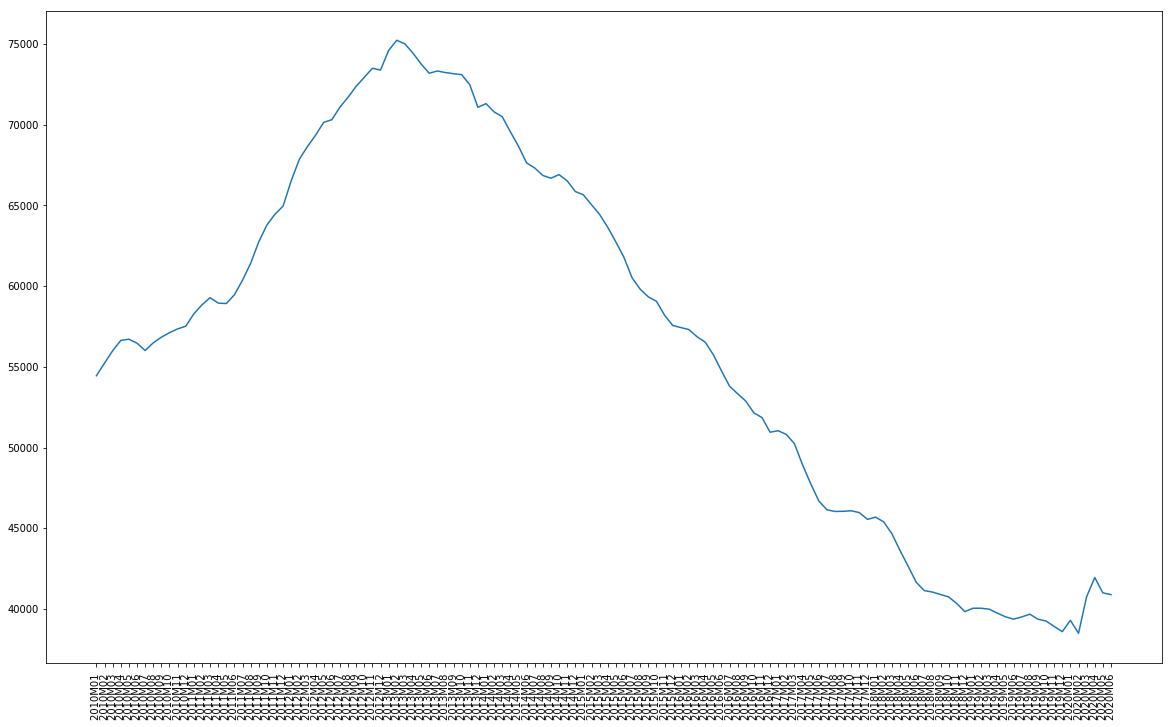

In [344]:
f, ax = plt.subplots(1,1, figsize=(20,12))

plt.plot(indexed_df.index,indexed_df['Value'])
#plt.plot(future_values, color='red')
plt.xticks(rotation=90)
plt.show()

In [353]:
indexed_df2 = indexed_df.reset_index()
indexed_df2

,Year_Month,Country,Year,Month,Value
0,2010M01,Spain,2010,1,54449.8
1,2010M02,Spain,2010,2,55234.1
2,2010M03,Spain,2010,3,55998.7
3,2010M04,Spain,2010,4,56638.2
4,2010M05,Spain,2010,5,56714.5
5,2010M06,Spain,2010,6,56467.8
6,2010M07,Spain,2010,7,56011.0
7,2010M08,Spain,2010,8,56489.1
8,2010M09,Spain,2010,9,56839.2
9,2010M10,Spain,2010,10,57117.0


In [354]:
indexed_df3 = pd.DataFrame(future_values)
indexed_df3.head()

,Value,Year_Month
0,41007.244622,2020M07
1,41122.109867,2020M08
2,41231.792221,2020M09
3,41336.482426,2020M10
4,41436.365524,2020M11


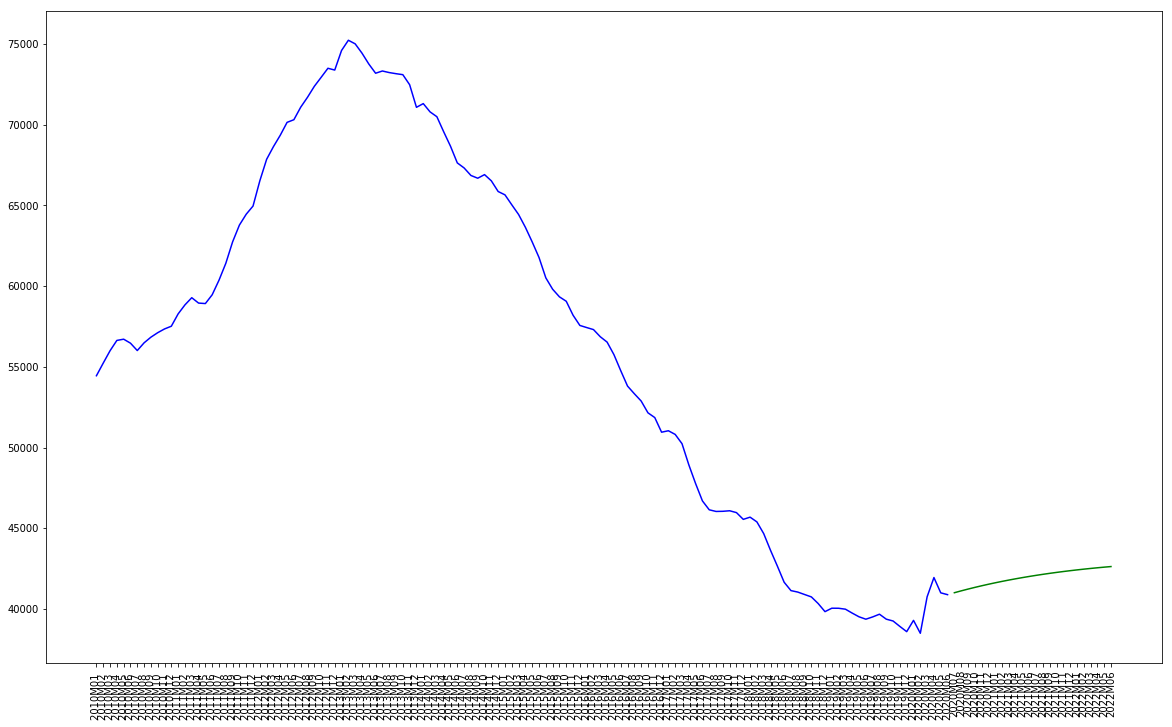

In [355]:
f, ax = plt.subplots(1,1, figsize=(20,12))

plt.plot(indexed_df.index,indexed_df['Value'], color="blue")
plt.plot(indexed_df3['Year_Month'], indexed_df3['Value'], color='green')
plt.xticks(rotation=90)
plt.show()